In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
if 'HOME' not in os.environ:
    os.environ['HOME'] = os.environ['USERPROFILE']

import juliet

import juliet
import astropy.io.fits as fits

problem: Could not find module 'libmultinest.dll' (or one of its dependencies). Try using the full path with constructor syntax.


Text(0, 0.5, 'Relative flux')

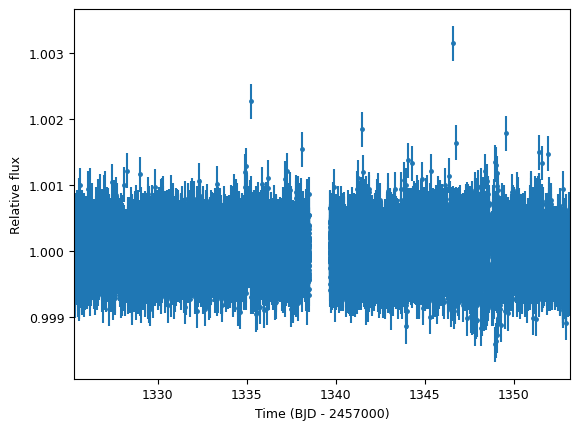

In [3]:
t,f,ferr  = juliet.get_TESS_data('https://archive.stsci.edu/hlsps/tess-data-alerts/'+\
                                 'hlsp_tess-data-alerts_tess_phot_00403224672-'+\
                                 's01_tess_v1_lc.fits')

# Plot the data!
import matplotlib.pyplot as plt
plt.errorbar(t,f,yerr=ferr,fmt='.')

plt.xlim([np.min(t),np.max(t)])
# plt.ylim([0.999,1.001])
plt.xlabel('Time (BJD - 2457000)')
plt.ylabel('Relative flux')

In [8]:
# Create dictionaries:
times, fluxes, fluxes_error = {},{},{}
# Save data into those dictionaries:
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t,f,ferr
# If you had data from other instruments you would do, e.g.,
# times['K2'], fluxes['K2'], fluxes_error['K2'] = t_k2,f_k2,ferr_k2

In [9]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS','q2_TESS','ecc_p1','omega_p1',\
              'rho', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[1.,0.1], [1325.55,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [100., 10000.], 1.0, [0.,0.1], [0.1, 1000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [10]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = 'toi141_fit_2')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 300)

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from toi141_fit_2/_dynesty_NS_posteriors.pkl


PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from toi141_fit_2/_dynesty_NS_posteriors.pkl


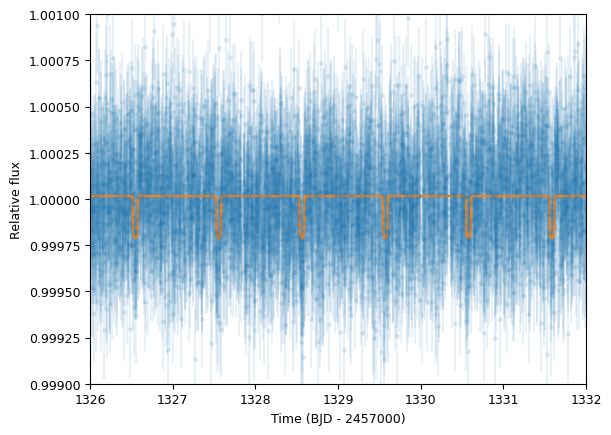

In [15]:
# Load already saved dataset with juliet:
dataset = juliet.load(input_folder = 'toi141_fit_2', out_folder = 'toi141_fit_2')

# Load results (the data.fit call will recognize the juliet output files in
# the toi141_fit folder generated when we ran the code for the first time):
results = dataset.fit()

import matplotlib.pyplot as plt

# Plot the data:
plt.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)

# Plot the model:
plt.plot(dataset.times_lc['TESS'], results.lc.evaluate('TESS'))

# Plot portion of the lightcurve, axes, etc.:
plt.xlim([1326,1332])
plt.ylim([0.999,1.001])
plt.xlabel('Time (BJD - 2457000)')
plt.ylabel('Relative flux')
plt.show()

(0.9985, 1.0015)

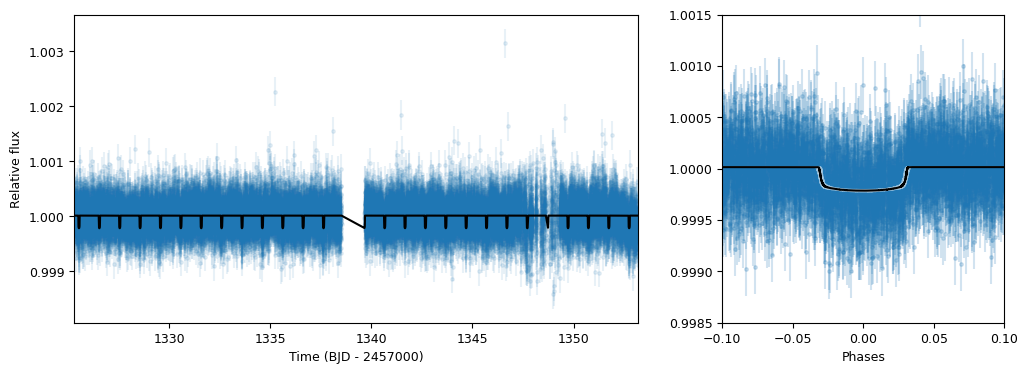

In [12]:
# Extract median model and the ones that cover the 68% credibility band around it:
transit_model, transit_up68, transit_low68  = results.lc.evaluate('TESS', return_err=True)

# To plot the phased lighcurve we need the median period and time-of-transit center:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']),\
        np.median(results.posteriors['posterior_samples']['t0_p1'])

# Get phases:
phases = juliet.get_phases(dataset.times_lc['TESS'], P, t0)


import matplotlib.gridspec as gridspec

# Plot the data. First, time versus flux --- plot only the median model here:
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.' , alpha = 0.1)

# Plot the median model:
ax1.plot(dataset.times_lc['TESS'], transit_model, color='black',zorder=10)

# Plot portion of the lightcurve, axes, etc.:
ax1.set_xlim([np.min(dataset.times_lc['TESS']),np.max(dataset.times_lc['TESS'])])
# ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

# Now plot phased model; plot the error band of the best-fit model here:
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.2)
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black',zorder=10)
ax2.fill_between(phases[idx],transit_up68[idx],transit_low68[idx],\
                 color='white',alpha=0.5,zorder=5)
ax2.set_xlabel('Phases')
ax2.set_xlim([-0.1,0.1])
ax2.set_ylim([0.9985,1.0015])

# Aqui empieza mi parte


In [43]:
LC = fits.open('WASP189_lightcurve3.fits')

In [44]:
#2457000
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = LC[1].data['TIME'],LC[1].data['FLUX'],LC[1].data['FLUX_ERR']
fluxes['TESS'] = fluxes['TESS'][times['TESS']<2720]
fluxes_error['TESS'] = fluxes_error['TESS'][times['TESS']<2720]
times['TESS'] = times['TESS'][times['TESS']<2720]

(2692.959017466804, 2717.539568615246)

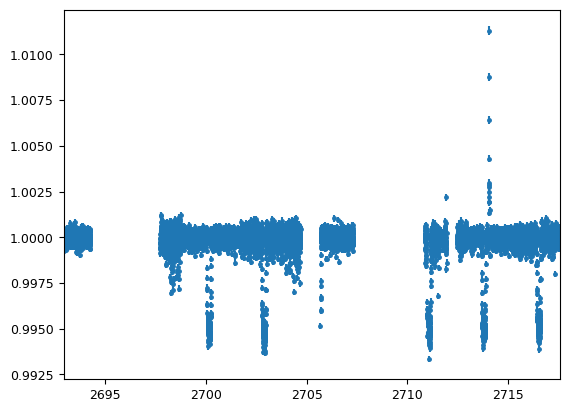

In [8]:
plt.errorbar(times['TESS'], fluxes['TESS'], yerr=fluxes_error['TESS'], fmt='.')
plt.xlim([np.min(times['TESS']),np.max(times['TESS'])])

In [9]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS','q2_TESS','ecc_p1','omega_p1',\
              'rho', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[2.7,3], [2700,10], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [100., 10000.], 1.0, [0.,0.1], [0.1, 1000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [ ]:
priors = {}


params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS','q2_TESS','ecc_p1','omega_p1',
          'rho', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS']


dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',
         'loguniform', 'normal', 'normal', 'loguniform']

# Solo ajusto hiperparámetros donde hace falta:
hyperps = [
    [2.7, 3],          
    [2700, 10],       
    [0., 1.],          
    [0., 1.],         
    [0., 1.],          
    [0., 1.],         
    0.0,               
    90.,             
    [200., 4000.],     
    [1.0, 0.02],       
    [0.0, 0.01],      
    [1e-5, 1e-2]      
]


for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [17]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = 'wasp 189fit5')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 300)
# results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.


18471it [11:23, 27.03it/s, +300 | bound: 408 | nc: 1 | ncall: 532316 | eff(%):  3.528 | loglstar:   -inf < 58131.731 <    inf | logz: 58071.406 +/-    nan | dlogz:  0.001 >  0.309]


PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from wasp 189fit5/_dynesty_NS_posteriors.pkl


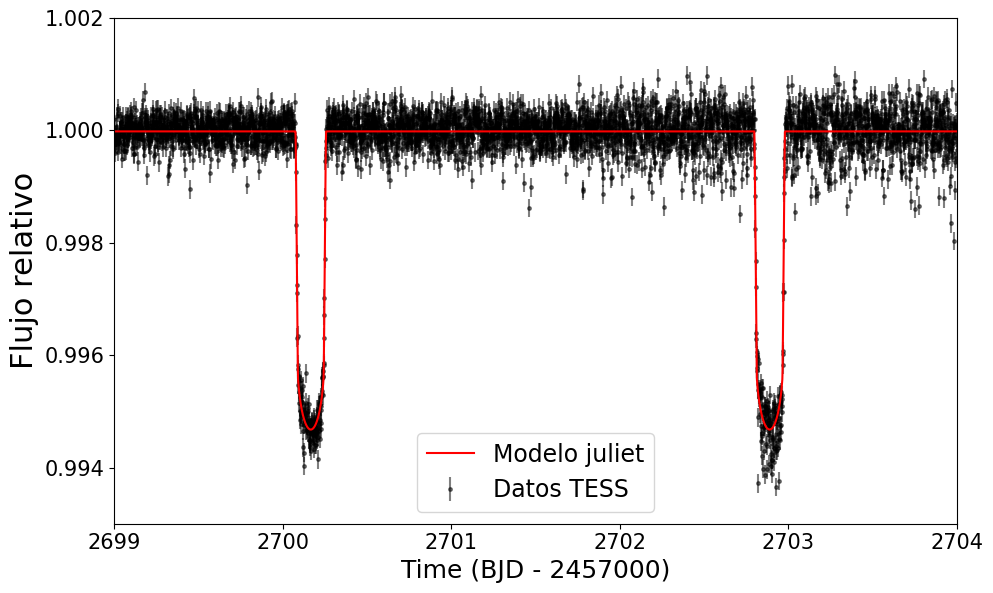

In [36]:
# Load already saved dataset with juliet:
dataset = juliet.load(input_folder = 'wasp 189fit5', out_folder = 'wasp 189fit5')

# Load results (the data.fit call will recognize the juliet output files in
# the toi141_fit folder generated when we ran the code for the first time):
results = dataset.fit()

import matplotlib.pyplot as plt

# Plot the data:
plt.figure(figsize=(10,6))
plt.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.5, zorder=1, c="black", label = "Datos TESS")

# Plot the model:
plt.plot(dataset.times_lc['TESS'], results.lc.evaluate('TESS'), alpha=1, zorder =2, c="red", label = "Modelo juliet")
# Plot portion of the lightcurve, axes, etc.:
plt.xlim(2699, 2700+4)
plt.ylim([0.993,1.002])
plt.xlabel('Time (BJD - 2457000)')
plt.ylabel("Flujo relativo", fontsize=22)
plt.xlabel("Time (BJD - 2457000)", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=17)
plt.savefig("Imagenes/wasp189_transit.png", dpi=300)
plt.show()

dict_keys(['unnamed', 'loglike', 'P_p1', 't0_p1', 'r1_p1', 'r2_p1', 'q1_TESS', 'q2_TESS', 'rho', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS'])


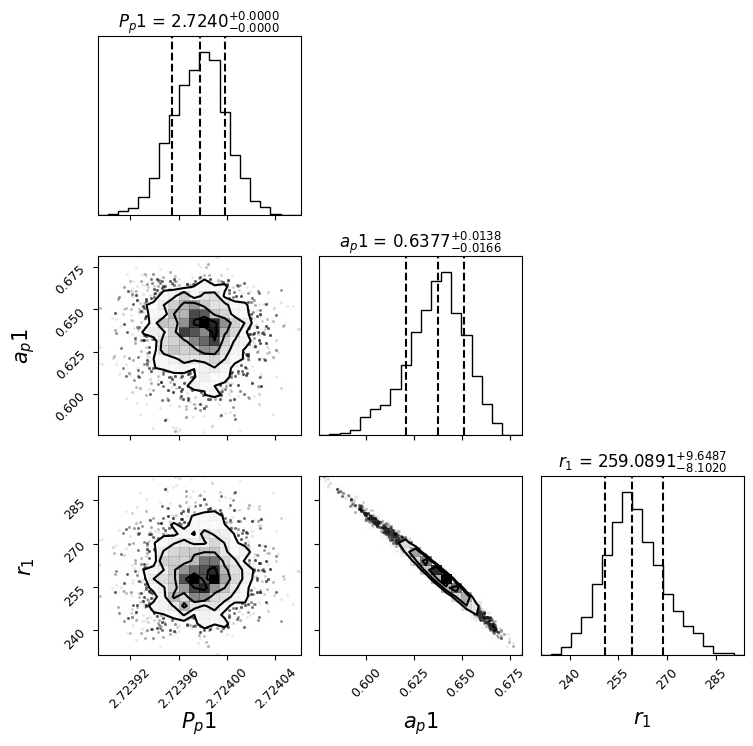

In [41]:
import corner
import numpy as np

print(results.posteriors["posterior_samples"].keys())
samples = np.column_stack([
    results.posteriors["posterior_samples"]['P_p1'],
    results.posteriors["posterior_samples"]['r1_p1'],

    results.posteriors["posterior_samples"]['rho']
])

fig = corner.corner(samples,
                    labels=[r"$P_p1$", r"$a_p1$", r"$r_1$", r"$\rho$"],
                    label_kwargs={"fontsize": 15},
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_fmt=".4f",
                    title_kwargs={"fontsize": 12})
plt.tight_layout()
plt.savefig("Imagenes/wasp189_cornertransit.png", dpi=300)
plt.show()

## Parte de rv

In [1]:
import pandas as pd
from astropy.time import Time

# Leer tu archivo original
df = pd.read_csv("vr_v5_ultimodia.txt", sep=r'\s+', comment='=', engine='python')

# Rango de archivos que quieres graficar
start_file = "archive/ADP.2023-06-05T01_02_22.459.fits"
end_file   = "archive/ADP.2023-06-07T01_04_24.749.fits"

# Filtrar el DataFrame
mask = (df['Archivo'] >= start_file) & (df['Archivo'] <= end_file)
df = df[mask]

# Convertir la columna Fecha a MJD (Modified Julian Date)
df["JD"] = [Time(f, format="isot", scale="utc").jd for f in df["Fecha"]]

# Crear una nueva tabla con el formato correcto
df_out = pd.DataFrame({
    "time_rv": df["JD"],
    "rv": df["VR_corr"],        # tu columna de velocidades
    "rv_err": df["Error"],      # errores
    "instrument": "HARPS"       # nombre del espectrógrafo
})

# Guardar en formato compatible con juliet
df_out.to_csv("v5_ultimodia.dat", sep="\t", index=False, header=False)


3059.6026782640256

In [51]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','mu_HARPS',\
          'K_p1', 'ecc_p1', 'omega_p1', 'sigma_w_HARPS']

# Distributions:
dists = ['normal','normal','uniform',\
         'uniform','fixed', 'fixed', 'loguniform']

# Hyperparameters
hyperps = [[2.7240330, 0.001], [2460099.72756713,0.005], [-40 ,1],\
           [0.1,0.3], 0., 90., [1e-3, 0.2]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

dataset = juliet.load(priors = priors, rvfilename='v5_ultimodia.dat', out_folder = 'WASP189_rv5_ultimo_dia')
results = dataset.fit(n_live_points = 300)

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from WASP189_rv5_ultimo_dia/_dynesty_NS_posteriors.pkl


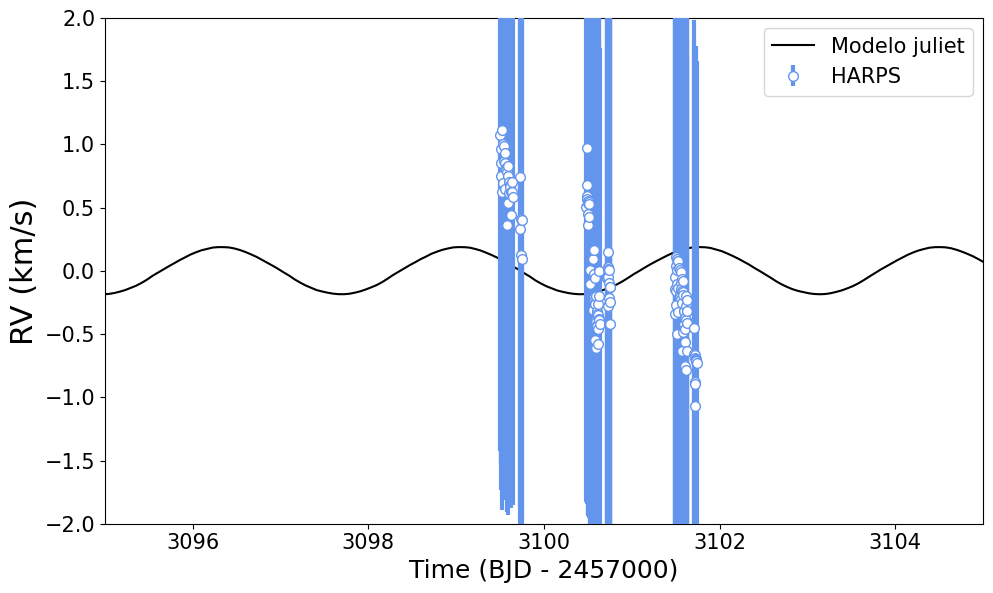

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Plot HARPS and FEROS datasets in the same panel. For this, first select any
# of the two and substract the systematic velocity to get the Keplerian signal.
# Let's do it with FEROS. First generate times on which to evaluate the model:
min_time, max_time = np.min(dataset.times_rv['HARPS'])-30,\
                     np.max(dataset.times_rv['HARPS'])+30

model_times = np.linspace(min_time,max_time,1000)

# Now evaluate the model in those times, and substract the systemic-velocity to
# get the Keplerian signal:
keplerian = results.rv.evaluate('HARPS', t = model_times) - \
            np.median(results.posteriors['posterior_samples']['mu_HARPS'])

# Now plot the (systematic-velocity corrected) RVs:
fig = plt.figure(figsize=(10,6))
instruments = ['HARPS']
colors = ['cornflowerblue','orangered']
for i in range(len(instruments)):
    instrument = instruments[i]
    # Evaluate the median jitter for the instrument:
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument])
    # Evaluate the median systemic-velocity:
    mu = np.median(results.posteriors['posterior_samples']['mu_'+instrument])
    # Plot original data with original errorbars:
    plt.errorbar(dataset.times_rv[instrument]-2457000,dataset.data_rv[instrument]-mu,\
                 yerr = dataset.errors_rv[instrument],fmt='o',\
                 mec=colors[i], ecolor=colors[i], elinewidth=3, mfc = 'white', \
                 ms = 7, label=instrument, zorder=10)

    # Plot original errorbars + jitter (added in quadrature):
    plt.errorbar(dataset.times_rv[instrument]-2457000,dataset.data_rv[instrument]-mu,\
                 yerr = np.sqrt(dataset.errors_rv[instrument]**2+jitter**2),fmt='o',\
                 mec=colors[i], ecolor=colors[i], mfc = 'white',\
                 alpha = 0.5, zorder=5)

# Plot Keplerian model:
plt.plot(model_times-2457000, keplerian,color='black',zorder=1, label='Modelo juliet')
plt.ylabel('RV (km/s)', fontsize=22)
plt.xlabel('Time (BJD - 2457000)', fontsize=18)

plt.ylim([-2,2])
plt.xlim([3100-5,3100+5])

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=15)
plt.savefig("Imagenes/wasp189_juliet_rv.png", dpi=300)
plt.show()


dict_keys(['unnamed', 'loglike', 'P_p1', 't0_p1', 'mu_HARPS', 'K_p1', 'sigma_w_HARPS'])


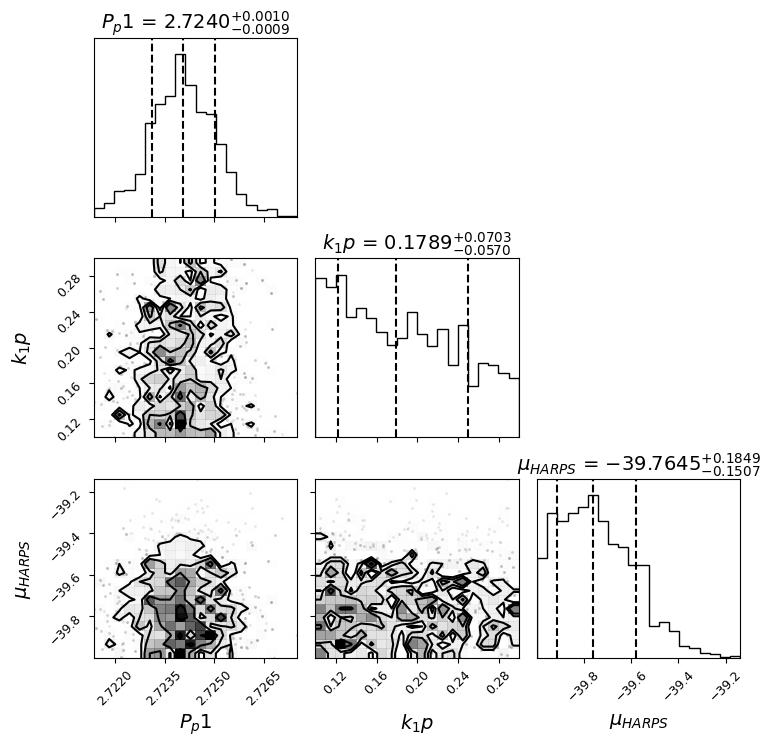

In [54]:
import corner

import corner
import numpy as np

print(results.posteriors["posterior_samples"].keys())
samples = np.column_stack([
    results.posteriors["posterior_samples"]['P_p1'],
    results.posteriors["posterior_samples"]['K_p1'],
    results.posteriors["posterior_samples"]['mu_HARPS']
])

fig = corner.corner(samples,
                    labels=[r"$P_p1$", r"$k_1p$", r"$\mu_{HARPS}$"],
                    label_kwargs={"fontsize": 14},
                    quantiles=[0.16, 0.5, 0.84],
                     show_titles=True,
                    title_fmt=".4f",
                    title_kwargs={"fontsize": 14})
plt.tight_layout()
plt.savefig("Imagenes/wasp189_corner_rv.png", dpi=300)
plt.show()

In [50]:
import pickle
import numpy as np

file = 'Master_spectrum_2025-10-27T04-12-44.p'
data = pickle.load(open(file, 'rb'))


# Cargar archivo .p
data = pickle.load(open('MASTER DE RASSINE\RASSINE_Master_spectrum_2025-10-28T004554.p', 'rb'))

print(data.keys())
# Extraer datos
data_output = data.get('output')
print(data_output.keys())

flux = data["flux_used"]
wave = data["wave"]




dict_keys(['wave', 'flux', 'flux_used', 'output', 'parameters', 'matching_anchors', 'matching_diff'])
dict_keys(['continuum_cubic', 'continuum_linear', 'anchor_wave', 'anchor_flux', 'anchor_index'])


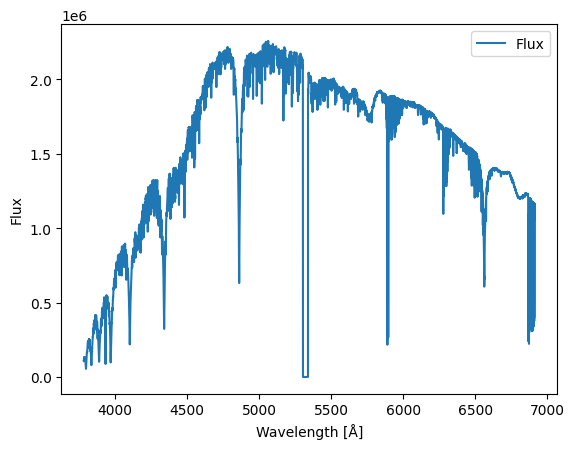

In [51]:
import matplotlib.pyplot as plt

plt.plot(wave, flux, label='Flux')

plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.legend()
plt.show()
